In [33]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import requests
import math
import urllib
import seaborn as sns
import json
from sklearn.feature_extraction import _stop_words
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
nltk.download('omw-1.4')
import shutil
from mpl_toolkits.basemap import Basemap
import zipfile
from zipfile import ZipFile
import os
import re
from fa2 import ForceAtlas2
import random

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\penna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\penna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\penna\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data importing, cleaning and preparing

In [2]:
url = 'https://raw.githubusercontent.com/d2ski/football-transfers-data/main/dataset/transfers.csv'
df = pd.read_csv(url)
#df=df[df['league']=='GB1'] # If you want to see results for all leagues simply comment this line

In [3]:
df['league'].unique()

array(['GB1', 'ES1', 'IT1', 'L1', 'FR1', 'PO1', 'NL1'], dtype=object)

In [4]:
print('We have in total %s European clubs which are buying or selling a total of %s players to %s differents clubs from all over the world'%(len(df['team_name'].unique()),len(df),len(df['counter_team_name'].unique())))

We have in total 243 European clubs which are buying or selling a total of 70006 players to 3610 differents clubs from all over the world


Getting cities/coordinates of clubs headquarters

In [5]:
df_geo=pd.read_csv('wikidata_query.csv')
#df_geo=df_geo[['clubLabel', 'Latitude', 'Longitude', 'Transfermarkt_team_ID', 'headquarters_locationLabel']]

In [6]:
df_geo['club'].replace('entity','wiki',inplace=True, regex=True)
df_geo.head()

,club,clubLabel,venue,venueLabel,coordinates,Longitude,Latitude,Transfermarkt_team_ID,headquarters_location,headquarters_locationLabel
0,http://www.wikidata.org/wiki/Q18528,Woking F.C.,http://www.wikidata.org/entity/Q6412727,Kingfield Stadium,Point(-0.558811 51.306333),-0.558811,51.306333,NaN,http://www.wikidata.org/entity/Q646225,Woking
1,http://www.wikidata.org/wiki/Q18529,Wrexham A.F.C.,http://www.wikidata.org/entity/Q1202579,Racecourse Ground,Point(-3.003611 53.051944),-3.003611,53.051944,1112.0,http://www.wikidata.org/entity/Q496368,Wrexham
2,http://www.wikidata.org/wiki/Q18656,Manchester United F.C.,http://www.wikidata.org/entity/Q83457,Old Trafford,Point(-2.291388888 53.463055555),-2.291389,53.463056,985.0,http://www.wikidata.org/entity/Q18125,Manchester
3,http://www.wikidata.org/wiki/Q18659,Swansea City A.F.C.,http://www.wikidata.org/entity/Q580480,Liberty Stadium,Point(-3.9351 51.6422),-3.935100,51.642200,2288.0,http://www.wikidata.org/entity/Q23051,Swansea
4,http://www.wikidata.org/wiki/Q18660,Altrincham F.C.,http://www.wikidata.org/entity/Q2440403,Moss Lane,Point(-2.335158 53.383436),-2.335158,53.383436,NaN,http://www.wikidata.org/entity/Q445058,Altrincham


Now we'll the wikipedia page content for each club, first we extract the link and then the content

In [7]:
def get_link(link):
    test_str = requests.get(link).text

    # initializing tag
    tag = 'span class="wikibase-sitelinkview-page" dir="auto" lang="en"'

    # regex to extract required strings
    reg_str = "<" + tag + ">(.*?)</" + 'span' + ">"
    res = re.findall(reg_str, str(test_str))

    reg_str = 'href="https://en.wikipedia.org/wiki/'+ "(.*?)" '"'
    res = re.findall(reg_str, str(res))
    if len(res)>0:
        return(res[0])

In [ ]:
df_geo['link']=df_geo['club'].apply(get_link)

In [ ]:
def addpage(character):
    try:
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = 'titles={}'.format(character)
        content = "prop=revisions&rvprop=content"
        dataformat ="format=json"
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        try:
            wikiresponse = urllib.request.urlopen(query)
        except UnicodeEncodeError:
            return (UnicodeEncodeError)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')
        try:
            imports = json.loads(wikitext)
        except json.JSONDecodeError:
            return("Empty response")
        try:           
            for key in imports['query']['pages'].keys():
                response=imports['query']['pages'][key]['revisions'][0]['*']
        except KeyError:
            return(KeyError)
        return response 
    except BaseException as error:
        return (error)

In [ ]:
df_geo['WikiContent']=df_geo['link'].apply(addpage)

Now we'll process the text

In [ ]:
def text_processing(text,lemmatizing=True,stop=True):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    if stop:
        text = " ".join([w for w in text.split() 
                         if w not in Stop_Words])
    if lemmatizing:
        # stemming / lematizing (optional)
        text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [ ]:
df_geo['WikiContent']=df_geo['WikiContent'].apply(text_processing)

We will run the sentiment analysis for each wiki page

In [ ]:
import nltk  #https://github.com/cjhutto/vaderSentiment
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
def sentiment(text):
    sia = SentimentIntensityAnalyzer()
    return(sia.polarity_scores(text))

In [ ]:
df_geo['sentiment']=df_geo['WikiContent'].apply(sentiment)

In [ ]:
df_geo2 = pd.concat([df_geo, pd.DataFrame(list(df_geo.sentiment))], axis=1)

In [ ]:
sns.distplot(df_geo2['compound']) #Histogram on sentiment values

In [ ]:
df_geo2.to_csv('Clubs_Sentiment_WikiContent.csv')

Now we'll do the same but for every player

In [ ]:
import warnings
warnings.filterwarnings("ignore")
df_players=pd.read_csv('football_players_link.csv',dtype={'association_football_player': 'str', 'Transfermarkt_player_ID': 'str'})
def is_float(x):
    try:
        float(x)
    except ValueError:
        return False
    return True
df_player=df_players[df_players['Transfermarkt_player_ID'].apply(lambda x: is_float(x))]
df_player.dropna(subset=['Transfermarkt_player_ID'],inplace=True)
df_player['Transfermarkt_player_ID']=df_player['Transfermarkt_player_ID'].astype(int)

In [ ]:
url = 'https://raw.githubusercontent.com/d2ski/football-transfers-data/main/dataset/transfers.csv'
df = pd.read_csv(url)
df['player_id']=df['player_id'].astype(int)

In [ ]:
df=df.merge(df_player,left_on='player_id',right_on='Transfermarkt_player_ID',how='left')
df.drop('Transfermarkt_player_ID',axis=1)
print('We have %s players with no link'%df.drop_duplicates(subset='player_id')['association_football_player'].isna().sum())

In [ ]:
df2=df.drop_duplicates(subset='player_id')
df2=df2.dropna(subset='association_football_player')
df2['association_football_player'].replace('entity','wiki',inplace=True, regex=True)
del df2['Transfermarkt_player_ID']

In [ ]:
df2['link']=df2['association_football_player'].apply(get_link)
df2['WikiContent']=df2['link'].apply(addpage)
df2['sentiment']=df2['WikiContent'].apply(sentiment)

In [ ]:
df3=df2.join(df2['sentiment'].apply(pd.Series))
df3=df3[['player_id','WikiContent','sentiment', 'neg','neu', 'pos', 'compound']]
df=df.merge(df3,on='player_id',how='left')

In [ ]:
df3

In [ ]:
sns.distplot(df3['compound']) #Histogram on sentiment values

In [ ]:
df=pd.read_csv('Transfers_Sentiment_WikiContent.csv',index_col=0)

Preparing for merging the club dataframe with the transfer dataframe

In [ ]:
df_geo=pd.read_csv('Clubs_Sentiment_WikiContent.csv',index_col=0)

In [ ]:
df_geo.rename(columns={'sentiment': 'sentiment_club', 'neg': 'neg_club', 'neu': 'neu_club', 'pos': 'pos_club', 'compound': 'compound_club','WikiContent':'WikiContent_club'}, inplace=True)
df.rename(columns={'sentiment': 'sentiment_player', 'neg': 'neg_player', 'neu': 'neu_player', 'pos': 'pos_player', 'compound': 'compound_player','WikiContent':'WikiContent_player'}, inplace=True)
df_geo=df_geo[['Longitude','Latitude', 'Transfermarkt_team_ID','WikiContent_club', 'sentiment_club','neg_club', 'neu_club', 'pos_club', 'compound_club','headquarters_locationLabel']]

In [ ]:
df=df[df.counter_team_id!='Retired'] # I was getting an error when transforming to integer
df_geo['Transfermarkt_team_ID']=df_geo['Transfermarkt_team_ID'].astype(int,errors='ignore')
df['team_id']=df['team_id'].astype(int)
df['counter_team_id']=df['counter_team_id'].astype(int)

Merging geographical data for clubs

In [ ]:
df=df.merge(df_geo,left_on='team_id',right_on='Transfermarkt_team_ID',how='left')
df=df.merge(df_geo,left_on='counter_team_id',right_on='Transfermarkt_team_ID',how='left',suffixes=('_team', '_counter_team'))
df.drop(['Transfermarkt_team_ID_team','Transfermarkt_team_ID_counter_team'],axis=1,inplace=True)

In [ ]:
print('We have %s rows with no info on the English team coordinates'%len(df[df['Latitude_team'].isna()]))
print('We have %s rows with no info on the other team coordinates'%len(df[df['Latitude_counter_team'].isna()]))

For those clubs that have no info on the location, we are going to assign the average latitude and longitude of the country they belong

In [ ]:
url = 'https://gist.githubusercontent.com/metal3d/5b925077e66194551df949de64e910f6/raw/c5f20a037409d96958553e2eb6b8251265c6fd63/country-coord.csv'
df_location_countries = pd.read_csv(url)
df_location_countries['Latitude (average)']=df_location_countries['Latitude (average)'].astype(int)
df_location_countries['Longitude (average)']=df_location_countries['Longitude (average)'].astype(int)

In [ ]:
df=df.merge(df_location_countries,left_on='team_country',right_on='Country',how='left')
df=df.merge(df_location_countries,left_on='counter_team_country',right_on='Country',how='left',suffixes=('_team', '_counter_team'))
for index,row in df[df['Latitude_counter_team'].isna()].iterrows():
    df.loc[index,'Latitude_counter_team']=df.loc[index,'Latitude (average)_counter_team']
    df.loc[index,'Longitude_counter_team']=df.loc[index,'Longitude (average)_counter_team']
for index,row in df[df['Latitude_team'].isna()].iterrows():
    df.loc[index,'Latitude_team']=df.loc[index,'Latitude (average)_team']
    df.loc[index,'Longitude_team']=df.loc[index,'Longitude (average)_team']

In [ ]:
print('Now, we have %s rows with no info on the other team coordinates'%len(df[df['Latitude_counter_team'].isna()]))
print('But, for example, we have %s rows that are minor division of the clubs, such as "Chelsea U18"'%len(df[df['counter_team_name'].str.match(r'(.* U[0-9][0-9]$)')==True]['counter_team_name']))
print('Also, we have %s rows that are Reserves division of the clubs, such as "Chelsea Reserves"'%len(df[df['counter_team_name'].str.match(r'(.* Reserves$)')==True]['counter_team_name']))

Now, we'll replace the latitude and longitude of the minor division with the major club

In [ ]:
for index,row in df.loc[(df['team_name'].str.match(r'(.* U[0-9][0-9]$)')==True)|(df['team_name'].str.match(r'(.* Reserves$)')==True)].iterrows():
    if pd.isna(row['Longitude_team']):
        for index2,row2 in df.drop_duplicates(subset='team_name').iterrows():
            if row2['team_name']==row['team_name'][:-4]:
                df.loc[index,'Latitude_team']=df.loc[index2,'Latitude_team']
                df.loc[index,'Longitude_team']=df.loc[index2,'Longitude_team']

In [ ]:
for index,row in df.loc[(df['counter_team_name'].str.match(r'(.* U[0-9][0-9]$)')==True)|(df['counter_team_name'].str.match(r'(.* Reserves$)')==True)].iterrows():
    if pd.isna(row['Longitude_counter_team']):
        for index2,row2 in df.drop_duplicates(subset='counter_team_name').iterrows():
            if row2['counter_team_name']==row['counter_team_name'][:-4]:
                df.loc[index,'Latitude_counter_team']=df.loc[index2,'Latitude_counter_team']
                df.loc[index,'Longitude_counter_team']=df.loc[index2,'Longitude_counter_team']

In [ ]:
print('We have %s rows with no info on the Enropean team coordinates'%len(df[df['Latitude_team'].isna()]))
print('Now, we have %s rows with no info on the other team coordinates. \nAs we can see below, most of them are small English clubs or player coming from no particular club.\nWe have to bear in mind there are 40,000 association football clubs in England, more than any other country'%len(df[df['Latitude_counter_team'].isna()]))
print(df[df['Latitude_counter_team'].isna()].groupby('counter_team_country').count()['team_id'])

Continent merging

In [ ]:
url='https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-continent.json'
df_continents = pd.read_json(url)
#df_continents.loc[63,'continent']='England'
new_rows = pd.DataFrame({'country': ['Without Club','Russia','Retired','Unknown','Ban','Bosnia-Herzegovina','Jersey','Kosovo','Career break',"Cote d'Ivoire", 'The Gambia', 'DR Congo', 'Libya', 'Réunion','Hongkong','Korea, North', 'Palästina','Brunei Darussalam', 'Chinese Taipei (Taiwan)', 'Korea, South','Neukaledonien','Tahiti','Curacao' ,'St. Lucia'],                        
                    'continent': ['No Club','Europe','Retired','Unknown','Ban','Europe','Europe','Europe','Retired','Africa','Africa','Africa','Africa','Africa','Asia','Asia','Asia','Asia','Asia','Asia','Oceania','Oceania','South America','North America']})
df_continents = df_continents.append(new_rows, ignore_index=True)
df=df.merge(df_continents,left_on='counter_team_country',right_on='country',how='left')
df=df.merge(df_continents,left_on='player_nation',right_on='country',how='left',suffixes=('_team','_player'))
df['continent_player'] = df['continent_player'].fillna('Unknown')

In [ ]:
df.drop(['country_player','country_team'],axis=1,inplace=True)

In [ ]:
df.drop([ 'Alpha-2 code_team', 'Alpha-3 code_team','Numeric code_team', 'Latitude (average)_team','Longitude (average)_team','Alpha-2 code_counter_team', 'Alpha-3 code_counter_team','Numeric code_counter_team', 'Latitude (average)_counter_team','Longitude (average)_counter_team',],axis=1,inplace=True)

In [ ]:
df.drop(['Country_team', 'Country_counter_team'],axis=1,inplace=True)

In [ ]:
df.drop(['WikiContent_club'],axis=1,inplace=True)
df.drop(['WikiContent_club_counter_team','WikiContent_club_team'],axis=1,inplace=True)

In [ ]:
df.to_csv('DF_WITH_SENTIMENT_.csv')

In [ ]:
compression = zipfile.ZIP_DEFLATED
zipObj = ZipFile('DFS.zip', 'w')
zipObj.write('DF_WITH_SENTIMENT_.csv',compress_type=compression)
zipObj.write('Transfers_Sentiment_WikiContent.csv',compress_type=compression)
zipObj.write('Clubs_Sentiment_WikiContent.csv',compress_type=compression)
zipObj.close()
os.remove("DF_WITH_SENTIMENT_.csv")
os.remove('Clubs_Sentiment_WikiContent.csv')
os.remove('Transfers_Sentiment_WikiContent.csv')

# In order to read the df, we first need to unzip the file

In [2]:
shutil.unpack_archive('DFS.zip')
df=pd.read_csv('DF_WITH_SENTIMENT_.csv')
df_clubs=pd.read_csv('Clubs_Sentiment_WikiContent.csv')
df_players=pd.read_csv('Transfers_Sentiment_WikiContent.csv')
os.remove("DF_WITH_SENTIMENT_.csv")
os.remove('Clubs_Sentiment_WikiContent.csv')
os.remove('Transfers_Sentiment_WikiContent.csv')

# Data visualization

Most selling countries to England among big leagues by year 

<AxesSubplot:xlabel='season'>

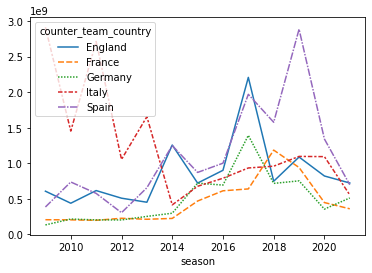

In [3]:
Big_five=['England','Italy','Spain','Germany','France']
df_fee_europe=df[df['dir']=='in']
df_fee_europe=df_fee_europe[df_fee_europe['counter_team_country'].isin(Big_five)]
fee_graph2=df_fee_europe.groupby(by=['season','counter_team_country']).sum()['transfer_fee_amnt']
sns.lineplot(data=fee_graph2.unstack())

Most buying countries from England among big leagues by year 

<AxesSubplot:xlabel='season'>

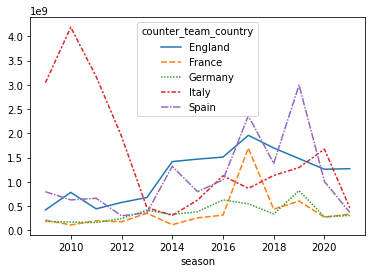

In [4]:
df_fee_europe=df[df['dir']=='left']
df_fee_europe=df_fee_europe[df_fee_europe['counter_team_country'].isin(Big_five)]
fee_graph2=df_fee_europe.groupby(by=['season','counter_team_country']).sum()['transfer_fee_amnt']
sns.lineplot(data=fee_graph2.unstack())

Most selling continent to England among rest of the world by year 

<AxesSubplot:xlabel='season'>

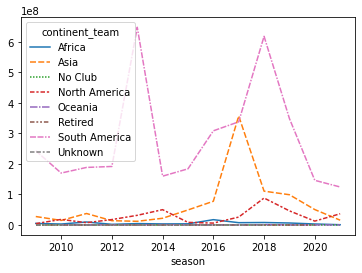

In [6]:
import seaborn as sns
df_fee=df[df['dir']=='in']
df_fee=df_fee.groupby(by=['season','continent_team']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack().drop(['Europe','Ban'],axis=1))

Most buying continents from England among rest of the world by year 

<AxesSubplot:xlabel='season'>

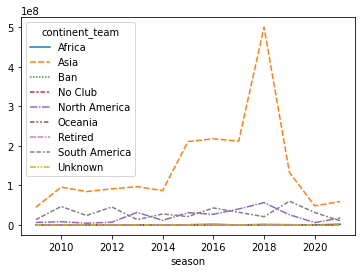

In [8]:
import seaborn as sns
df_fee=df[df['dir']=='left']
df_fee=df_fee.groupby(by=['season','continent_team']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack().drop(['Europe'],axis=1))

Difference between in and out players fee by year

<AxesSubplot:xlabel='season'>

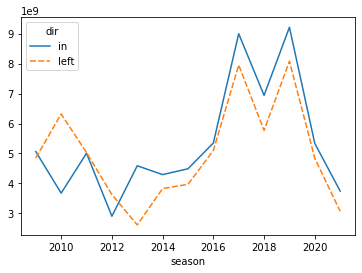

In [9]:
df_fee=df.groupby(by=['season','dir']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack())

Sum of fees by player age

<AxesSubplot:xlabel='player_age'>

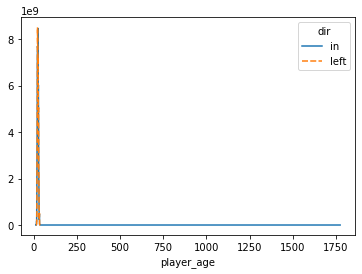

In [10]:
df_fee=df.groupby(by=['player_age','dir']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack())

# Network code

This one is updated for every country I believe

In [59]:
G = nx.MultiDiGraph()
for index, row in df.iterrows():
    #if row['team_country'] == 'England' or row['counter_team_country'] == 'England':
        #if row['team_name'] not in G.nodes():
            #G.add_node(row['team_name'], league=row['team_country'],continent='England')
    if row['counter_team_name'] not in G.nodes():
        G.add_node(row['counter_team_name'], league=row['counter_team_country'],continent=row['continent_team'])
for index, row in df.iterrows():
    #if row['team_country'] == 'England' or row['counter_team_country'] == 'England':
    if math.isnan(row['transfer_fee_amnt']):
        tmpfee = 0
    else:
        tmpfee = row['transfer_fee_amnt']
    if row['dir'] == 'in':
        G.add_edge(row['counter_team_name'],row['team_name'], player = row['player_name'], fee = tmpfee,nationality=row['player_nation'],continent_player=row['continent_player'])
    else:
        G.add_edge(row['team_name'],row['counter_team_name'], player = row['player_name'], fee = tmpfee,nationality=row['player_nation'],continent_player=row['continent_player'])

In [12]:
tmpset = set(nx.get_node_attributes(G, 'league').values())

In [13]:
inthash = dict()
counter = 1
for i in tmpset:
    inthash[i] = counter
    counter+=1

In [16]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
#colors = [inthash[nx.get_node_attributes(G, 'league')[i]]/len(tmpset) for i in G.nodes()]
#colors = ['red' if nx.get_node_attributes(G, 'league')[i] == 'England' else 'blue' for i in G.nodes()]
#plt.figure(figsize=(16,16)) 
#plt.axis([-1500, 1500, -1500, 1500])
#nx.draw(G, pos=positions, node_color=colors, edge_color='black', arrows=True, arrowsize=10, node_size=35)
#txt="Our graph plotted with forceatlas, colours being worlds red=marvel, blue=dc and nodesize being based on node degree"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
#plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:39<00:00, 12.58it/s]

BarnesHut Approximation  took  23.06  seconds
Repulsion forces  took  132.53  seconds
Gravitational forces  took  0.37  seconds
Attraction forces  took  0.34  seconds
AdjustSpeedAndApplyForces step  took  1.42  seconds


In [ ]:
# color_map = nx.get_node_attributes(G,'continent')
# for key in color_map:
#     if color_map[key] == 'England':
#         color_map[key] = 'red'
#     elif color_map[key] == 'Europe':
#         color_map[key] = 'blue'
#     elif color_map[key] == 'Africa':
#         color_map[key] = 'yellow'
#     elif color_map[key] == 'Asia':
#         color_map[key] = 'green'
#     elif color_map[key] == 'North America':
#         color_map[key] = 'pink'
#     elif color_map[key] == 'Oceania':
#         color_map[key] = 'brown'
#     elif color_map[key] == 'South America':
#         color_map[key] = 'purple'
#     else:
#         color_map[key] = 'gray'
# contcolor = [color_map.get(node) for node in G.nodes()]
# plt.figure(figsize=(16,16)) 
# nx.draw(G, pos=positions, node_color=contcolor, edge_color='black', arrows=True, arrowsize=10, node_size=35)

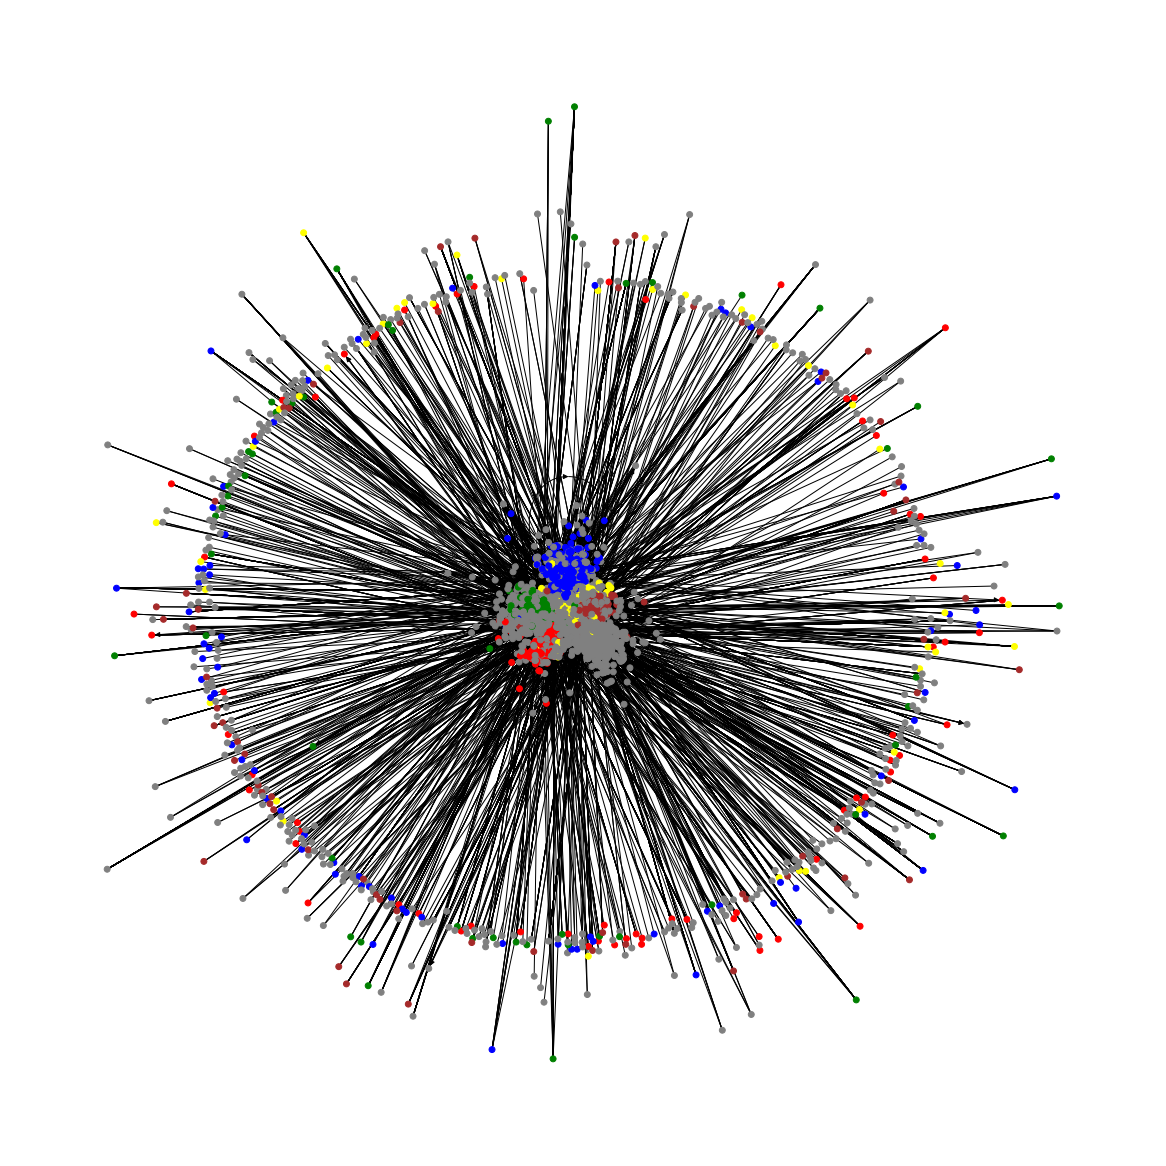

In [17]:
colors = ['red' if nx.get_node_attributes(G, 'league')[i] == 'England' else 'yellow' if nx.get_node_attributes(G, 'league')[i] == 'Spain'
          else 'blue' if nx.get_node_attributes(G, 'league')[i] == 'Italy' else 'green' if nx.get_node_attributes(G, 'league')[i] == 'Germany' 
          else 'brown' if nx.get_node_attributes(G, 'league')[i] == 'France' else 'gray' for i in G.nodes()]
plt.figure(figsize=(16,16)) 
#plt.axis([-1500, 1500, -1500, 1500])
nx.draw(G, pos=positions, node_color=colors, edge_color='black', arrows=True, arrowsize=10, node_size=35)

In [18]:
nx.write_gexf(G, 'wip.gexf')

In [60]:
#df.dropna(subset=['Longitude_counter_team','Latitude_counter_team'],inplace=True)

plt.figure(figsize = (14,12))
m = Basemap(projection='merc',llcrnrlon=-130,llcrnrlat=-40,urcrnrlon=180, 
urcrnrlat=60, lat_ts=0, resolution='l',suppress_ticks=True)

mx, my = m(df['Longitude_counter_team'].values,df['Latitude_counter_team'].values)
pos = {}
for count, elem in enumerate (df['counter_team_name']):
    pos[elem] = (mx[count], my[count])
    
d = dict(G.degree)
#nx.draw_networkx_edges(G, pos = pos, edge_color='blue', alpha=0.1, arrows = False,node_size=[v * 100 for v in d.values()])
nx.draw(G, pos = pos, edge_color='blue', alpha=0.1, arrows = False,node_size=[v * 0.1 for v in d.values()])
m.drawcountries(linewidth = 2)
#m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
#plt.tight_layout()
plt.savefig("map.png", dpi = 300)
plt.show()

ValueError: need at least one array to concatenate

<Figure size 1008x864 with 1 Axes>

In [58]:
#df.dropna(subset=['Longitude_counter_team','Latitude_counter_team'],inplace=True)

plt.figure(figsize = (10,20))
m = Basemap(projection='merc',llcrnrlon=-10,llcrnrlat=30,urcrnrlon=20, 
urcrnrlat=60, lat_ts=0, resolution='l',suppress_ticks=True)

mx, my = m(df['Longitude_counter_team'].values,df['Latitude_counter_team'].values)
pos = {}
for count, elem in enumerate (df['counter_team_name']):
    pos[elem] = (mx[count], my[count])
    
d = dict(G.degree)
#nx.draw_networkx_edges(G, pos = pos, edge_color='blue', alpha=0.1, arrows = False,node_size=[v * 100 for v in d.values()])
nx.draw(G, pos = pos, edge_color='blue', alpha=0.01, arrows = False,node_size=[v * 2 for v in d.values()])
m.drawcountries(linewidth = 2)
m.drawstates(linewidth = 0.9)
m.drawcoastlines(linewidth=1)
#plt.tight_layout()
plt.savefig("map_England.png", dpi = 300)
plt.show()


ValueError: need at least one array to concatenate

<Figure size 720x1440 with 1 Axes>

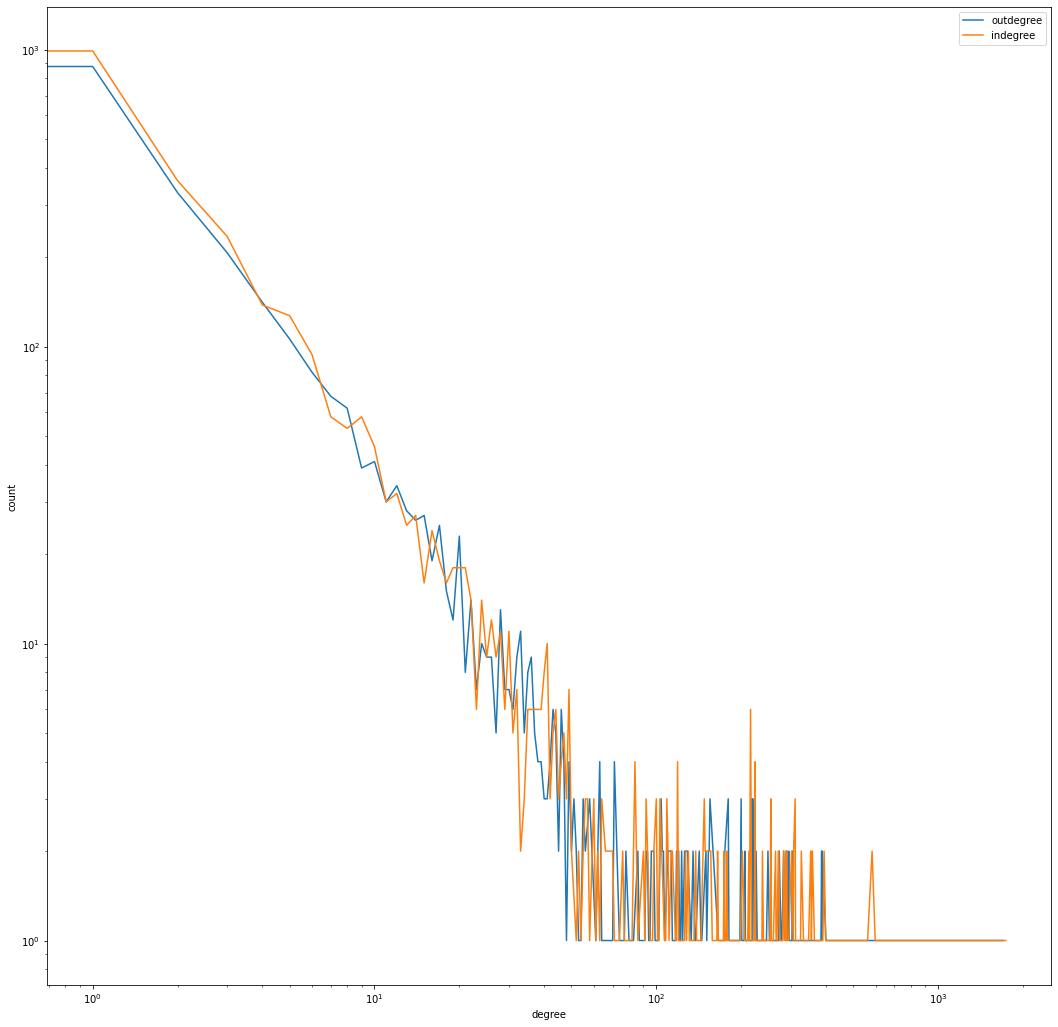

In [26]:
outdegree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)
indegree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
fig = plt.figure("Degree distribution of football transfers graph", figsize=(18, 18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('count')
plt.plot(*np.unique(outdegree_sequence, return_counts=True), label='outdegree')
plt.plot(*np.unique(indegree_sequence, return_counts=True), label='indegree')
plt.legend()
plt.show()

In [45]:
diameter = nx.diameter(G.to_undirected())
print('diameter of the network (if undirected)', diameter)
print('average shortest path in the network', nx.average_shortest_path_length(G))

diameter of the network (if undirected) 5
average shortest path in the network 1.86590027456611


In [35]:
truth = 0
for i in range(10000):
    rs = random.choice(list(G.nodes()))
    friends = G.degree(rs)
    nb = G.neighbors(rs)
    avnb = 0
    for j in nb:
        avnb+=G.degree(j)
    avnb = avnb/friends
    if avnb > friends:
        truth+=1
print('friendship paradox holds true for',truth, 'out of 10000 trials')

friendship paradox holds true for 6403 out of 10000 trials


In [44]:
#average degree of network
print('average degree of our network:', np.mean(sorted((d for n, d in G.degree()), reverse=True)))
print('lnn of our network:', math.log(len(G.nodes())))

average degree of our network: 41.377666943751734
lnn of our network: 8.19118600464279


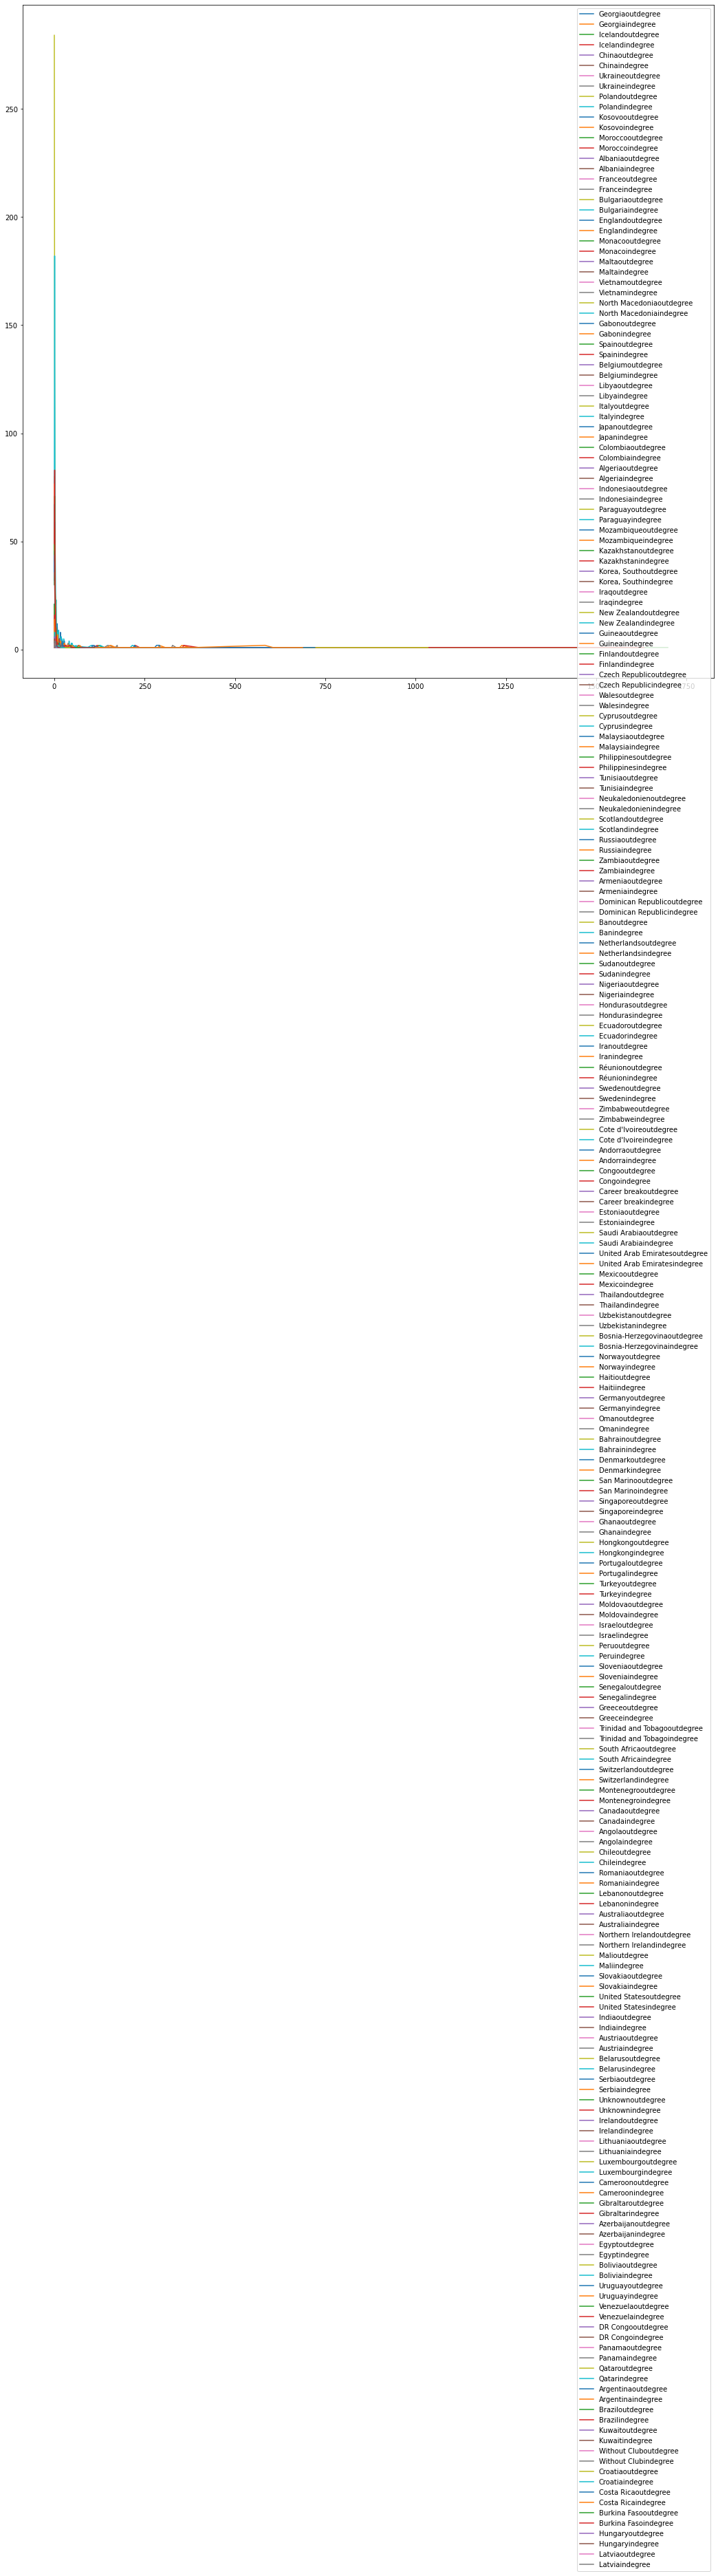

In [46]:
#nx.get_node_attributes(G, 'league')
fig = plt.figure("Degree of a random graph", figsize=(18, 18))
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    outdegree_sequence = sorted((d for n, d in G.out_degree() if n in tmpnodes), reverse=True)
    indegree_sequence = sorted((d for n, d in G.in_degree() if n in tmpnodes), reverse=True)
    plt.plot(*np.unique(outdegree_sequence, return_counts=True), label=i+'outdegree')
    plt.plot(*np.unique(indegree_sequence, return_counts=True), label=i+'indegree')
plt.legend()
plt.show()

In [47]:
transferstocountry = dict()
transfersfromcountry = dict()
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    outdegree_sequence = sorted((d for n, d in G.out_degree() if n in tmpnodes), reverse=True)
    transfersfromcountry[i] = sum(outdegree_sequence)
    indegree_sequence = sorted((d for n, d in G.in_degree() if n in tmpnodes), reverse=True)
    transferstocountry[i] = sum(indegree_sequence)

In [72]:
sorted_ttc = sorted(transferstocountry.items(), key=lambda x:x[1], reverse=True)
sorted_tfc = sorted(transfersfromcountry.items(), key=lambda x:x[1], reverse=True)
print('transfers to country')
print(sorted_ttc[0:10])
print('transfers from country')
print(sorted_tfc[0:10])

transfers to country
[('Italy', 14387), ('England', 10838), ('Spain', 10318), ('Portugal', 9616), ('France', 6940), ('Germany', 6731), ('Netherlands', 6277), ('Without Club', 1738), ('Brazil', 891), ('Turkey', 756)]
transfers from country
[('Italy', 15664), ('England', 10627), ('Spain', 10421), ('Portugal', 9740), ('France', 7376), ('Germany', 6913), ('Netherlands', 6674), ('Brazil', 1117), ('Belgium', 629), ('Without Club', 536)]


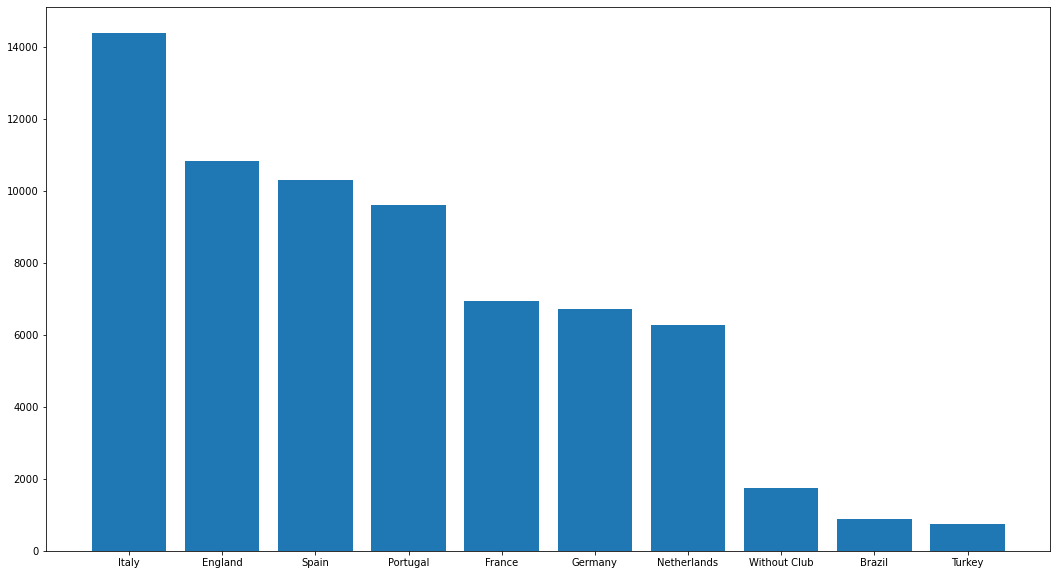

In [71]:
x = []
y = []
for i in sorted_ttc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries buying players", figsize=(18, 10))
plt.bar(x,y)
plt.show()

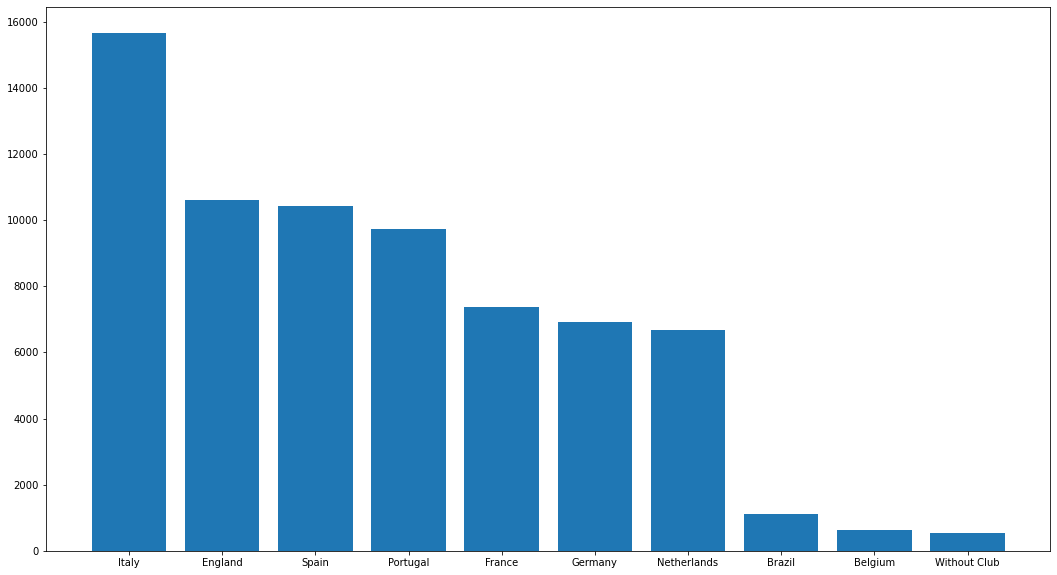

In [73]:
x = []
y = []
for i in sorted_tfc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries selling players", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [63]:
nx.get_edge_attributes(G, 'fee')
transferfeetocountry = dict()
transferfeefromcountry = dict()
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    tmpfrom = [z['fee'] for f, t, z in G.edges(data=True) if f in tmpnodes]
    transferfeefromcountry[i] = sum(tmpfrom)
    tmpto = [z['fee'] for f, t, z in G.edges(data=True) if t in tmpnodes]
    transferfeetocountry[i] = sum(tmpto)

In [64]:
counter = 0
for x,y,z in G.edges(data=True):
    counter+=1

In [65]:
sorted_tftc = sorted(transferfeetocountry.items(), key=lambda x:x[1], reverse=True)
sorted_tffc = sorted(transferfeefromcountry.items(), key=lambda x:x[1], reverse=True)
print('transfers to country')
print(sorted_tftc[1:11])
print('transfers from country')
print(sorted_tffc[1:11])

transfers to country
[('England', 33416719000.0), ('Spain', 31060880000.0), ('Germany', 11856664000.0), ('France', 11770933000.0), ('Portugal', 2325648000.0), ('Netherlands', 1370760000.0), ('Russia', 1164650000.0), ('China', 949365000.0), ('Turkey', 494276000.0), ('Brazil', 290855000.0)]
transfers from country
[('Spain', 29081128000.0), ('England', 21077994000.0), ('Germany', 12852060000.0), ('France', 11955716000.0), ('Portugal', 6680004000.0), ('Netherlands', 5383625000.0), ('Brazil', 2514886000.0), ('Belgium', 1012310000.0), ('Argentina', 761645000.0), ('Russia', 563109000.0)]


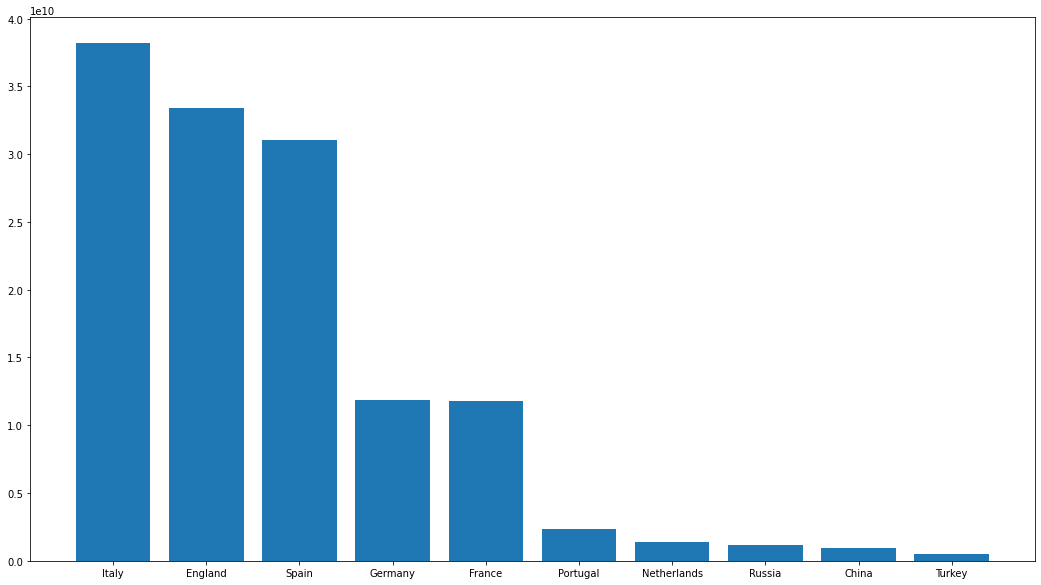

In [66]:
x = []
y = []
for i in sorted_tftc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries buying players by fee", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [55]:
print(transferfeefromcountry['Spain'])
print(transferfeefromcountry['Italy'])

29081128000.0
37593332000.0


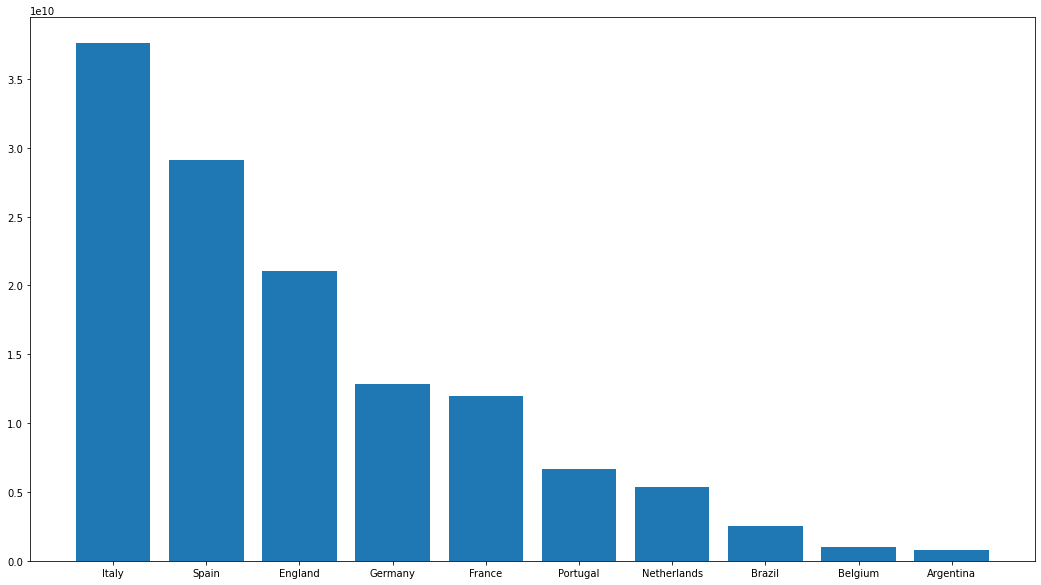

In [68]:
x = []
y = []
for i in sorted_tffc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries selling players by fee", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [70]:
df_fee

player_age  dir 
12.0        in      0.0
14.0        in      0.0
            left    0.0
15.0        in      0.0
            left    0.0
                   ... 
41.0        left    0.0
42.0        in      0.0
            left    0.0
43.0        left    0.0
1775.0      in      0.0
Name: transfer_fee_amnt, Length: 61, dtype: float64